In [1]:
# Loop through images in a folder
import os

# Replace with your main folder path
main_folder = './28_aug_all_tif'

# List to store image file paths
tiff_files = []

# Walk through all directories and subdirectories
for root, dirs, files in os.walk(main_folder):
    for file in files:
        if file.lower().endswith(('.tif', '.tiff')):
            tiff_files.append(os.path.join(root, file))

print(f"Found {len(tiff_files)} TIFF images.")

# DISPLAY FILE NAMES
#for r in range (len(tiff_files)):
for r in range (5):
    print (tiff_files[r])

Found 7 TIFF images.
./28_aug_all_tif/R1_28Aug23_index_nir.tif
./28_aug_all_tif/R1_28Aug23_index_panchro.tif
./28_aug_all_tif/R1_28Aug23_index_ndvi.tif
./28_aug_all_tif/R1_28Aug23_index_red.tif
./28_aug_all_tif/R1_28Aug23_index_red_edge.tif


In [2]:
import os
ndvi_file_path = ""

from collections import OrderedDict

# Main dictionary to hold metadata + empty stats section
Region = OrderedDict()

for r in range (len(tiff_files)):
    # file path
    file_path = tiff_files[r]
    # Get the filename without path
    filename = os.path.basename(file_path)
    
    # Remove extension
    name = os.path.splitext(filename)[0]

    # Split by underscores
    parts = name.split('_')
    region = parts[0].lower()      # 'r1'
    date = parts[1]                # '7Sept23'
    index = '_'.join(parts[2:])    # 'index_norm2'
    if index == "index_ndvi":
        ndvi_file_path = filename

        Region[name] = OrderedDict([('region', region),
        ('date', date),
        ('index', index),
        ('pixel_values', [])])

print (ndvi_file_path)
print (Region)

R1_28Aug23_index_ndvi.tif
OrderedDict({'R1_28Aug23_index_ndvi': OrderedDict({'region': 'r1', 'date': '28Aug23', 'index': 'index_ndvi', 'pixel_values': []})})


In [3]:
!pip install rasterio

In [4]:
# plot histogram function
import rasterio
import numpy as np
from rasterio.windows import from_bounds
from scipy import stats  # Only needed for mode
import matplotlib.pyplot as plt

def statistical_measure (dict, sub_key_val, sub_value_val):
    hist_keys = []
    for key, value in dict.items():
        #print(f"File: {key}")
        for sub_key, sub_value in value.items():
            if sub_key == sub_key_val and sub_value == sub_value_val:
                for r in range (len(tiff_files)):    
                    if key in tiff_files[r]:
                        #print (tiff_files[r])
                        image_path = tiff_files[r]
                        with rasterio.open(image_path) as src:
                            # Extract image bounds and transform
                            bounds = src.bounds
                            transform = src.transform
                            nodata = src.nodata
                        
                            # Get window from bounding box
                            window = from_bounds(bounds.left, bounds.bottom, bounds.right, bounds.top, transform=transform)
                        
                            # Read the indice_values values in the bounding box
                            indice_values = src.read(1, window=window)
                        
                            # Mask nodata values
                            if nodata is not None:
                                indice_values = np.ma.masked_equal(indice_values, nodata)
                        # Flatten the array for stats
                        pixel_values = indice_values.compressed()     
                        Region[key]['pixel_values'] = pixel_values
                        #print (pixel_values)
                        hist_keys.append(key)
    return hist_keys

In [5]:
# Get pixel values of indices and plot histograms (NDVI) w.r.t indices
histogram_keys_ndvi = statistical_measure(Region, 'index', 'index_ndvi')
print (histogram_keys_ndvi)

['R1_28Aug23_index_ndvi']


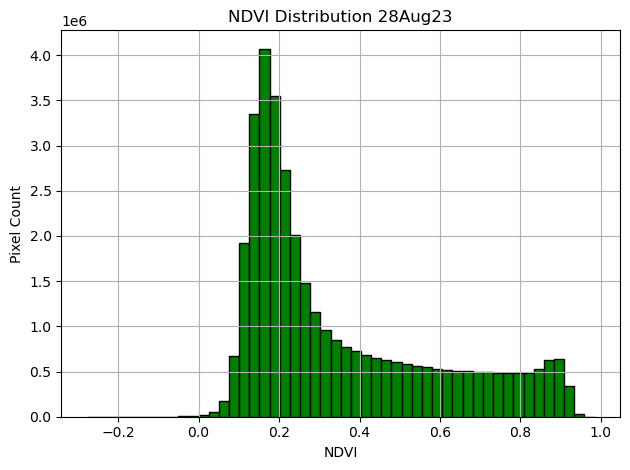

In [6]:
plt.hist(Region[histogram_keys_ndvi[0]]['pixel_values'], bins=50, color='green', edgecolor='black')
plt.title(f"NDVI Distribution {Region[histogram_keys_ndvi[0]]['date']}")
plt.xlabel("NDVI")
plt.ylabel("Pixel Count")
plt.grid(True)

plt.tight_layout()
plt.show()